In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

C:\Users\ABANERJ7\AppData\Local\Temp\ipykernel_27272\2791906692.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Ice Cream Production Data

In [2]:
#read data
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True)

C:\Users\ABANERJ7\AppData\Local\Temp\ipykernel_27272\4252961792.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True)


In [3]:
production_ice_cream.sample(5)

DATE
2002-11-01    114.5562
1998-06-01    149.2407
2017-12-01     75.8118
2001-05-01    131.9872
2017-10-01     90.4732
Name: IPN31152N, dtype: float64

In [4]:
production_ice_cream.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 577 entries, 1972-01-01 to 2020-01-01
Series name: IPN31152N
Non-Null Count  Dtype  
--------------  -----  
577 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
production_ice_cream.rename('production',inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [6]:
pd.infer_freq(production_ice_cream.index)

'MS'

The output 'MS' returned by pd.infer_freq(production_ice_cream.index) means that the inferred frequency of the time series data stored in the production_ice_cream DataFrame is "Month Start" frequency.

In pandas, MS stands for "Month Start". It is a frequency code used to represent the starting day of each month. This frequency code is often used to represent monthly data where each observation represents the starting point of a month.

For example, if the first observation in the production_ice_cream DataFrame is January 1, 2010, and the second observation is February 1, 2010, then the inferred frequency of the data would be "Month Start" or 'MS'. This means that the data has a frequency of one observation per month, where each observation represents the start of a month.

In [7]:
production_ice_cream.sample(6)

DATE
2007-01-01    126.2649
2003-04-01    151.4035
2009-05-01    137.9925
2017-06-01    123.0870
2008-01-01    107.9956
2001-10-01    115.1136
Name: production, dtype: float64

In [8]:
#infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

production_ice_cream.asfreq : It would only keep the first date of every month and its values and remove the remaining.

In [9]:
production_ice_cream.asfreq

<bound method Series.asfreq of DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64>

In [10]:
production_ice_cream.sample(6)

DATE
2014-08-01    111.4180
1980-04-01     87.9979
1991-05-01    127.9323
2007-06-01    180.0874
1977-02-01     75.0613
1976-11-01     67.5320
Name: production, dtype: float64

In [11]:
#Get the data from 2010 onwards
production_ice_cream = production_ice_cream[production_ice_cream.index.year >= 2010]

In [12]:
production_ice_cream.index.year

Int64Index([2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2020],
           dtype='int64', name='DATE', length=121)

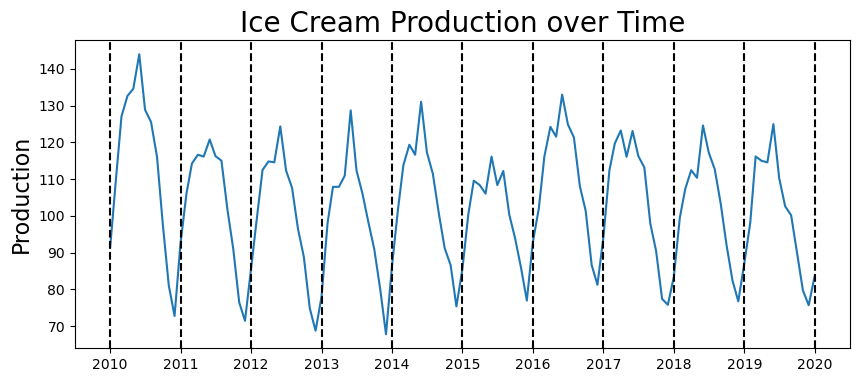

In [13]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production',fontsize=16)

for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01')
                ,color='k',linestyle='--')

## ACF

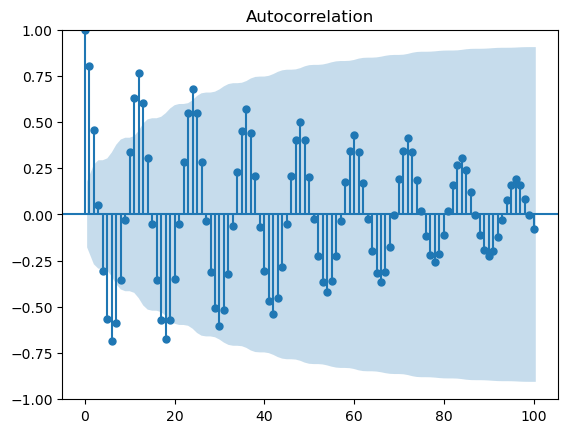

In [14]:
acf_plot = plot_acf(production_ice_cream,lags=100)

### Based on decaying ACF, we are likely dealing with an Auto regressive process

## PACF

C:\Users\ABANERJ7\AppData\Local\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


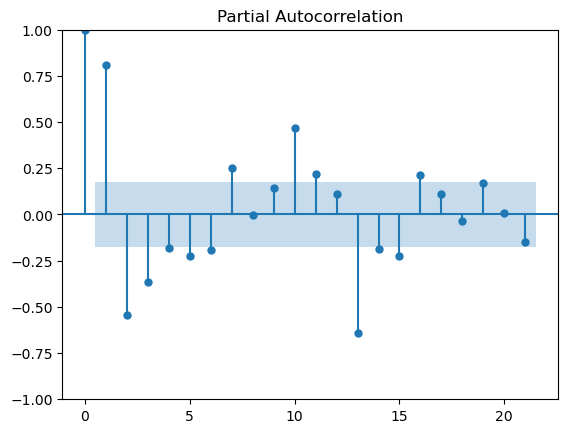

In [15]:
pacf_plot = plot_pacf(production_ice_cream)

### Based on PACF, we should start with an Auto Regressive model with lags 1,2,3

## Get Training and Testing sets

In [16]:
train_end = datetime(2018,12,1)
#train_end = pd.Timestamp('2018-12-01')
train_end

datetime.datetime(2018, 12, 1, 0, 0)

In [17]:
test_end = datetime(2019,12,1)
test_end

datetime.datetime(2019, 12, 1, 0, 0)

In [18]:
#training data contains 9 years of data from 2010 to end of 2018
train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

## Fit the AR Model

In [19]:
#create the model
#--> to remove a certain error, we use the below import
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(3,0,0))
#here we have allocated d as 0 to treat it like ARMA and not ARIMA

#### Create an ARIMA model with (p,d,q) = (3,0,0)
p is the order of the autoregressive (AR) part of the model, which captures the linear relationship between the current value and its previous values. It refers to the number of lag observations included in the model.

d is the degree of differencing required to make the time series stationary. Differencing refers to taking the difference between consecutive observations. If the original time series is not stationary, differencing can be used to remove the trend or seasonality.

q is the order of the moving average (MA) part of the model, which captures the linear relationship between the current value and the moving average of the past errors. It refers to the size of the moving average window.

In [20]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time : {end - start}")

Model Fitting Time : 0.03840947151184082


In [21]:
# Summary of model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Mon, 24 Apr 2023   AIC                            758.170
Time:                        22:16:07   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.765      -0.396       0.291
ar.L3         -0.4044      0.123     -3.290      0.001      -0.645      -0.164
sigma2        58.4026      9.475      6.164      0.000      39.831      76.974
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 8.71
Prob(Q):                              0.43   Prob(JB):                         0.01
Heteroskedasticity (H):               0.76   Skew:                             0.70
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Observation : 
P-value (Here its P>|z|)  should always be less or equal to 0.05 to be significant.
We can see ar.L1(lag 1) and ar.L3(lag 3) have P-value less than 0.05 which is significant but ar.L2 has more so its not significant.
So, here its best to create AR model with LAG 1 and 3 excluding LAG 2.


In [22]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [23]:
test_data

DATE
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
2019-06-01    124.9605
2019-07-01    110.2632
2019-08-01    102.6085
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
Freq: MS, Name: production, dtype: float64

In [24]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date,
                       end=pred_end_date        
                               )
residuals = test_data - predictions

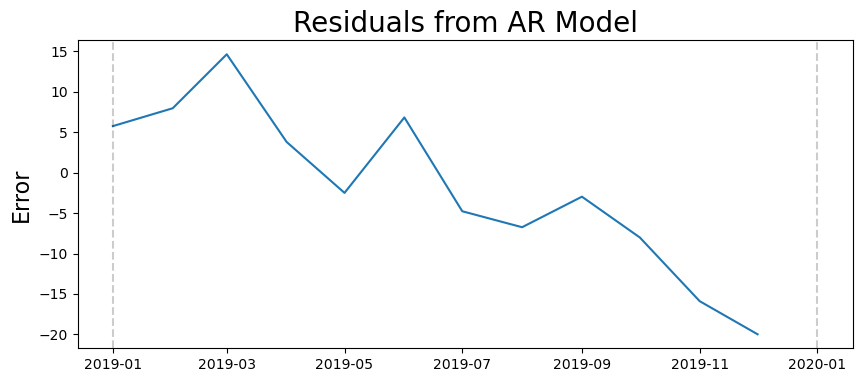

In [25]:
#Plotting the residuals to see how much accurate is the prediction
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
#plt.axvline(0,color='r',linestyle='--',alpha=0.2)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),
               color='k', linestyle='--',alpha=0.2)

The residuals are decreasing over time so there's a clear pattern in the residual which is not something we want. So there's something in the data we didnt capture

C:\Users\ABANERJ7\AppData\Local\Temp\ipykernel_27272\610851965.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Data','Predictions')


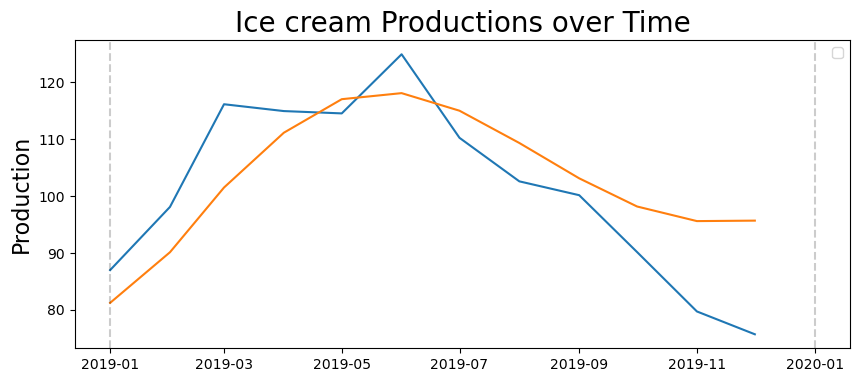

In [26]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend('Data','Predictions')

plt.title('Ice cream Productions over Time',fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),
               color='k', linestyle='--',alpha=0.2)

In [27]:
#Mean Absolute Percentage Error
round(np.mean(abs(residuals/test_data)),4)

0.0895

In [28]:
#Root Mean Square Error
np.sqrt(np.mean(residuals**2))

9.884158749316368